In [13]:
import pandas as pd
import numpy as np
import cv2, os
import torch
import torch.nn as nn
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.metrics import classification_report, confusion_matrix, precision_score,recall_score,f1_score, roc_curve, roc_auc_score, matthews_corrcoef
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import torch_directml
import shutil
from scores import score_in_details
torch.manual_seed(240)

In [2]:
dml = torch_directml.device()

In [3]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size = (224, 224)),
        transforms.ToTensor(),
        ])

In [4]:
class MyDataset(Dataset):
    def __init__(self, ds, transform):
        self.ds = ds
        self.transform = transform
                
    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):            
        image_path = self.ds[idx][0]
        label = self.ds[idx][1]
        img = cv2.imread(image_path)
        img = self.transform(img)
            
        return {"image": img,
                "labels": label,
                "path": image_path}

In [5]:
dataset_path = "../splitted"
test_dataset = dsets.ImageFolder(root=f'{dataset_path}/test/')
test_ds = MyDataset(ds=test_dataset.imgs, transform=transform)

In [6]:
test_loader = DataLoader(test_ds, batch_size=20, drop_last=True, shuffle=False)

In [7]:
def create_model():
    model = torchvision.models.densenet121(weights="IMAGENET1K_V1")
    
    model.classifier = nn.Linear(1024, 2)
    return model.to(dml)

base_model = create_model()

In [8]:
model_path = "../trained-models/densenet-121.pt"
base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)

<All keys matched successfully>

In [9]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    base_model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs = batch['image'].to(dml)
            labels = batch['labels'].to(dml)
            path = batch["path"]
            
            outputs = softmax(base_model(inputs))
            
            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():   
                pred_probas.append(list(probs))
            preds = preds.cpu()
            labels = labels.cpu()
            predictions.extend(preds)
            real_values.extend(labels)
            
            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    misclassified.append((path[ind], actual, pred))
            
    return predictions, real_values, pred_probas, misclassified

In [10]:
pred, real, probas, misclassified = get_predictions()
print(classification_report([y_actual.item() for y_actual in real], [y_pred.item() for y_pred in pred], digits=6))

  0%|          | 0/943 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0   0.951066  0.978879  0.964772      4924
           1   0.992459  0.982204  0.987305     13936

    accuracy                       0.981336     18860
   macro avg   0.971762  0.980542  0.976039     18860
weighted avg   0.981652  0.981336  0.981422     18860



Accuracy: 98.13361611876988%
Precision: 0.9816522120798106
Recall: 0.9813361611876988
F1-score: 0.981422184900107
MCC-score: 0.9522636461733018
ROC AUC score: 0.7163568721606303




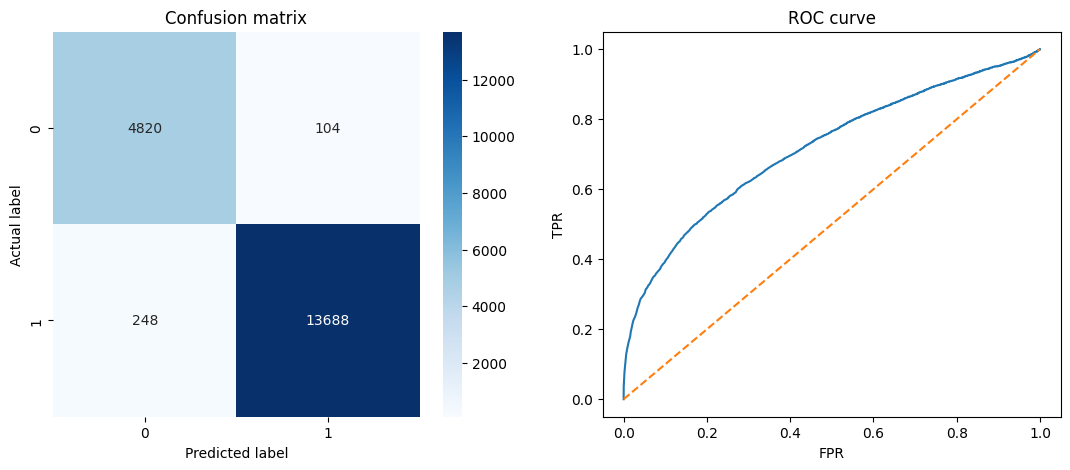

In [14]:
score_in_details(pred=pred, real=real, probas=probas)

In [12]:
dest = "../images/misclassified-new/densenet-121"
for path, actual, pred in tqdm(misclassified):
    img_name = path.split("\\")[-1].split(".")[0]
    ext = path.split(".")[-1]
    shutil.copy(path, os.path.join(dest, f"{img_name}_{actual.item()}_{pred.item()}.{ext}"))

  0%|          | 0/352 [00:00<?, ?it/s]